In [1]:
import numpy as np
from sklearn_ensemble_cv import Ensemble, comp_empirical_ecv, ECV

We make up some fake data for illustration.

In [2]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

X, y = make_regression(n_samples=300, n_features=100,
                       n_informative=10, n_targets=1,
                       random_state=0, shuffle=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# The Ensemble class

For users who want to have more control of the ensemble predictor, this section introduces lower-level class and object that we use to implement the cross-validation methods.
For users who just want to use easy interface functions, you can safely skip this section.

We provide `Ensemble` a class for ensemble predictor, whose base class is `sklearn.ensemble.BaggingRegressor`.
This means that the usage of `Ensemble` is basically the same as the latter, except the new class includes several new member functions that we will illustrate below.



## Initialize an object

The initialization of `Ensemble` class is the same as `sklearn.ensemble.BaggingRegressor`, where 

1. The base estimator object, whose hyperparameter `kwargs_regr` is specified when it is initialized. In the following example, we use decision tree as the base estimator. 
2. The hyperparameters for building an ensemble, such as `n_estimators`, `max_samples`, `max_features`, and etc.

In [3]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr = Ensemble(estimator=DecisionTreeRegressor(**kwargs_regr), n_estimators=100, **kwargs_ensemble)

After the ensemble object `regr` is initialized, we can fit the data and get the prediction:

In [4]:
regr.fit(X_train, y_train)
regr.predict(X_test)

array([   3.3085772 , -149.27073693,  -79.23123588,  -46.12580357,
         35.42487033,  -95.13184675,   30.24254277,  -64.91709221,
        -32.55947774,  126.31338862,   34.88489559, -163.0571926 ,
        207.66058938,  -52.47314725,  134.27570611,   72.63811587,
        -69.84360362, -115.06378651,  -27.53163965,  -13.38144276,
          1.29337076, -115.69859066,   -7.99013127,  128.14076236,
         47.5896881 ,  -16.49412859,   30.61089975,  -50.85873924,
         34.88450162,  -46.5627095 ,  -87.83000026,   68.20018095,
       -122.00274699,   -1.98271459,  -65.64268333,  -26.81817217,
        -28.84689861,   78.45547962,  212.38563318,  101.6272712 ,
        151.37828173,  124.85537988,    3.00042038,   63.33404423,
         91.54279666,  -97.44363735,  167.47644976,   61.16851949,
       -174.13195624,  -17.83295841,   89.86404921, -178.20531941,
         76.0683331 ,   55.53349424,  129.33311537, -105.56217971,
        100.90299823,   94.33784225,  -90.92953266,   12.77484

## Prediction of individual estimators

We provide a new function `predict_individual` to obtain prediction values from all estimators in the ensemble.
Since we have $n=150$ observations and $M=10$ estimators, the resulting prediction would be of shape $(n,M)=(150,10)$.

In [5]:
Y_train_hat = regr.predict_individual(X_train)
Y_train_hat.shape

(150, 100)

## Compute ECV estimate of the prediction risk

Below, we use function `compute_ecv_estimate` to estimate the prediction risk for various ensemble size $M=1,\ldots,100$, only using the first $M_0=20$ trees.

In [6]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M0=20, return_df=True)
df_est

,M,estimate
0,1,55269.183904
1,2,38845.586115
2,3,33371.053518
3,4,30633.787220
4,5,28991.427441
...,...,...
95,96,22764.146612
96,97,22760.619207
97,98,22757.163790
98,99,22753.778179


We can also compute the test error on the test set using function `compute_risk`. 

In [7]:
df_risk = regr.compute_risk(X_test, y_test, return_df=True)
df_risk

,M,risk
0,1,59671.446170
1,2,39878.709142
2,3,33630.454551
3,4,28791.135433
4,5,29764.254971
...,...,...
95,96,23187.442370
96,97,23079.431197
97,98,22940.916585
98,99,23000.578746


If we plot both the risk estimate and the actual test error, we see a close match.

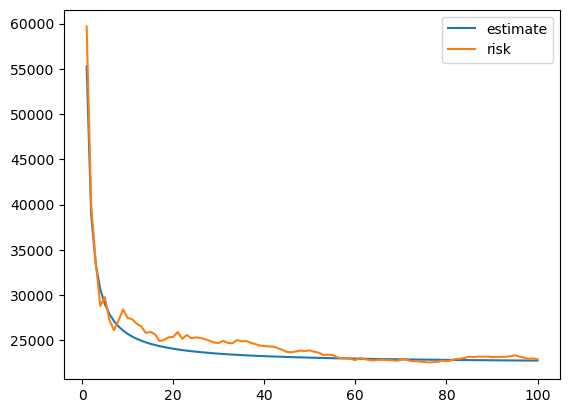

In [8]:
import matplotlib.pyplot as plt
plt.plot(df_est['M'], df_est['estimate'], label='estimate')
plt.plot(df_risk['M'], df_risk['risk'], label='risk')
plt.legend()
plt.show()

Above we show two basic functions and their usage.
One utility of ECV method is that we can also get a risk estimate beyond $M=100$, which gives us a sense how much improvement one can get if we further increase the ensemble size.

In [9]:
df_est = regr.compute_ecv_estimate(X_train, y_train, M_test=1000, M0=20, return_df=True)
df_est

,M,estimate
0,1,55269.183904
1,2,38845.586115
2,3,33371.053518
3,4,30633.787220
4,5,28991.427441
...,...,...
995,996,22454.967437
996,997,22454.934359
997,998,22454.901347
998,999,22454.868401


# ECV estimate for one configuration of ensemble predictors


The function `comp_empirical_ecv` provides an easy way to fit and get risk estimate from ECV.
Similar to the previous section, one need to provide
1. Data: `X_train, y_train`.
2. A regressor class and the parameters to initialize it: `DecisionTreeRegressor, kwargs_regr=kwargs_regr`.
3. The parameters for building the ensemble (with `M` denoting `n_estimators`): `kwargs_ensemble=kwargs_ensemble, M=100`.
4. Extra optional parameters for ECV.

The function returns two objects:
1. An ensemble predictor (an object of `Ensemble`)
2. A np.array or pd.DataFrame object, containing the risk estimates given by ECV.

In [10]:
from sklearn.tree import DecisionTreeRegressor
kwargs_regr = {'max_depth': 7}
kwargs_ensemble = {'max_samples': 0.8}
regr, risk_ecv = comp_empirical_ecv(X_train, y_train, DecisionTreeRegressor, kwargs_regr=kwargs_regr,
                   kwargs_ensemble=kwargs_ensemble, M=100)

One can also pass kwargs `X_val=X_test, Y_val=y_test` to get the actual test errors.

# ECV for tuning hyperparameters

For tuning hyperparameters, such as `max_samples` and `max_features` for the ensemble predictors, and `max_depth` and `min_samples_leaf` for all base predictors, we can make two grids of these two types of tuning hyperparameters respectively.

We recommend using `np.array` for each parameter, and make sure to use the correct dtypes that `sklearn` accept.
If one want to set some hyperparameter to a fix value, simply provide it in the grid as either a scalar or a list/array with length one.

In [11]:
# Hyperparameters for the base regressor
grid_regr = {    
    'max_depth':np.array([6,7], dtype=int), 
    }
# Hyperparameters for the ensemble
grid_ensemble = {
    'max_features':np.array([0.9,1.]),
    'max_samples':np.array([0.6,0.7]),
}

res_ecv, info_ecv = ECV(
    X_train, y_train, DecisionTreeRegressor, grid_regr, grid_ensemble, M=100,  return_df=True
)

In [12]:
res_ecv

,max_depth,max_features,max_samples,risk_ecv-1,risk_ecv-2,risk_ecv-3,risk_ecv-4,risk_ecv-5,risk_ecv-6,risk_ecv-7,...,risk_ecv-91,risk_ecv-92,risk_ecv-93,risk_ecv-94,risk_ecv-95,risk_ecv-96,risk_ecv-97,risk_ecv-98,risk_ecv-99,risk_ecv-100
0,6,0.9,0.6,84603.218847,63517.222287,56488.556767,52974.224007,50865.624351,49459.891247,48455.796173,...,42894.654223,42889.616956,42884.688018,42879.863951,42875.141444,42870.517322,42865.988542,42861.552187,42857.205455,42852.945658
1,6,0.9,0.7,81475.586912,61042.637832,54231.654806,50826.163293,48782.868385,47420.671779,46447.674204,...,41058.764557,41053.883298,41049.107013,41044.432350,41039.856102,41035.375192,41030.986672,41026.687714,41022.475603,41018.347735
2,6,1.0,0.6,56002.876479,38094.286526,32124.756542,29139.991550,27349.132554,26155.226558,25302.436560,...,20579.291957,20575.013746,20570.827540,20566.730402,20562.719520,20558.792197,20554.945851,20551.178001,20547.486269,20543.868372
3,6,1.0,0.7,55704.430084,37994.405217,32091.063594,29139.392783,27368.390296,26187.721972,25344.387454,...,20673.611665,20669.380890,20665.241099,20661.189389,20657.222978,20653.339200,20649.535501,20645.809428,20642.158629,20638.580846
4,7,0.9,0.6,85245.722882,62660.389724,55131.945338,51367.723145,49109.189829,47603.500952,46528.008897,...,40571.437515,40566.042070,40560.762656,40555.595569,40550.537264,40545.584340,40540.733538,40535.981733,40531.325923,40526.763229
5,7,0.9,0.7,82109.634568,60194.544308,52889.514222,49236.999179,47045.490153,45584.484135,44540.908409,...,38761.104384,38755.869054,38750.746312,38745.732565,38740.824370,38736.018429,38731.311580,38726.700789,38722.183145,38717.755854
6,7,1.0,0.6,56452.372986,38485.495975,32496.536972,29502.057470,27705.369769,26507.577969,25652.012397,...,20913.495383,20909.203248,20905.003417,20900.892944,20896.869007,20892.928903,20889.070037,20885.289924,20881.586177,20877.956505
7,7,1.0,0.7,54492.245476,37431.483033,31744.562219,28901.101812,27195.025568,26057.641405,25245.224146,...,20745.682402,20741.606731,20737.618708,20733.715536,20729.894537,20726.153141,20722.488888,20718.899416,20715.382458,20711.935839


In [13]:
info_ecv

{'delta': 0.0,
 'best_params_regr': {'max_depth': 6},
 'best_params_ensemble': {'max_features': 1.0, 'max_samples': 0.6},
 'best_n_estimators': inf,
 'M_max': inf}